In [7]:
import numpy as np 
import pandas as pd 
import seaborn as sns

import matplotlib.pyplot as plt
import re

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
data = pd.read_csv('/content/spam_ham_dataset.csv')
data

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [9]:
data = data.drop(['Unnamed: 0', 'label'], axis=1)
data = data.rename(columns = {"label_num" : "Label"})
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5171 non-null   object
 1   Label   5171 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.9+ KB


,text,Label
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


## Visualization

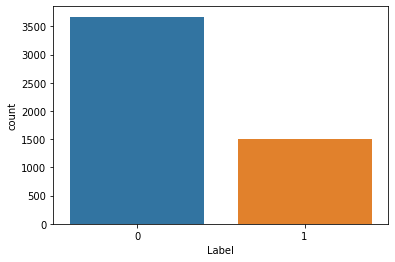

In [ ]:
graph1 = sns.countplot(x="Label", data = data)

Text(0.5, 1.0, 'Spam Word Cloud')

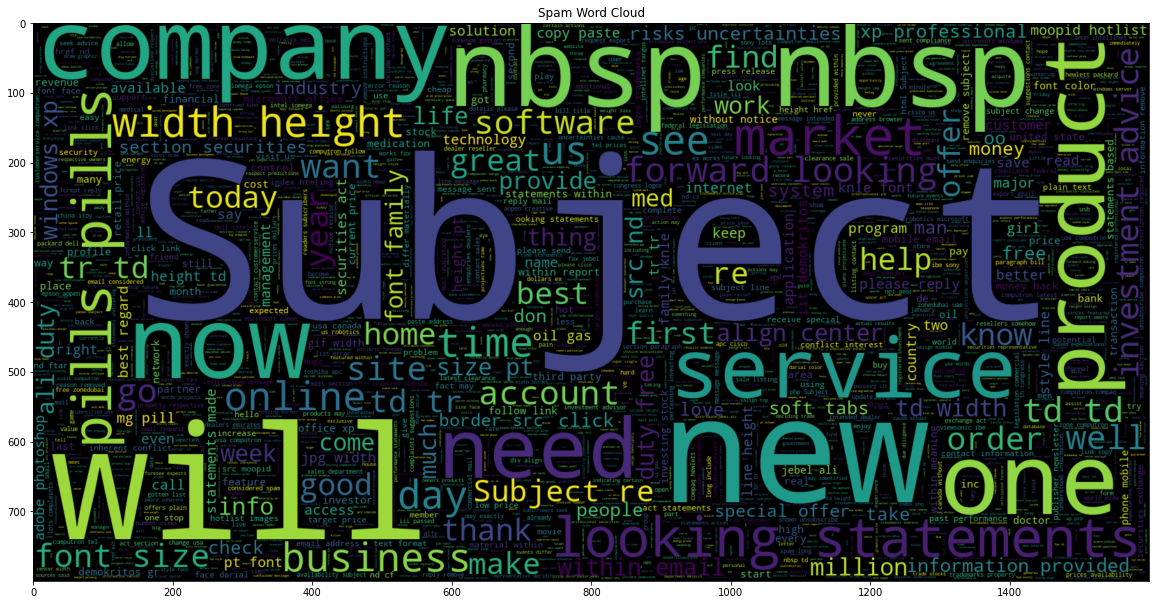

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.Label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Spam Word Cloud")

## Data Cleaning

In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"

In [11]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data.text = data.text.apply(lambda x: preprocess(x,stem=True))
data.head()

,text,Label
0,subject: enron methanol ; meter # : 988291 fol...,0
1,"subject: hpl nom januari 9 , 2001 ( see attach...",0
2,"subject: neon retreat ho ho ho , ' around wond...",0
3,"subject: photoshop , window , offic . cheap . ...",1
4,subject: : indian spring deal book teco pvr re...,0


## DataSets Split

In [12]:
x = data['text']
y = data['Label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                         random_state=7)
print("Train Data size:", len(x_train))
print("Test Data size", len(x_test))

Train Data size: 4136
Test Data size 1035


# Data to batshes

In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train = pad_sequences(tokenizer.texts_to_sequences(x_train),
                        maxlen = 50)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),
                       maxlen = 50)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (4136, 50)
Testing X Shape: (1035, 50)


# RNN

In [14]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, Dropout

rnn = Sequential()
rnn.add(SimpleRNN(512, activation='relu', input_dim=50 , return_sequences = True))
rnn.add(SimpleRNN(256, activation='relu', return_sequences = True))
rnn.add(SimpleRNN(64, activation='relu' ,  return_sequences = False))
#Adding dropout to prevent overfitting
#rnn.add(Dropout(0.1))
rnn.add(Dense(1, activation='sigmoid'))

In [ ]:
rnn.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_40 (SimpleRNN)   (None, None, 512)         288256    
                                                                 
 simple_rnn_41 (SimpleRNN)   (None, None, 256)         196864    
                                                                 
 simple_rnn_42 (SimpleRNN)   (None, 64)                20544     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 505,729
Trainable params: 505,729
Non-trainable params: 0
_________________________________________________________________


In [15]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
x_train1 = x_train.reshape(4136,1,50)
y_train1 = np.array(y_train).reshape(4136,1,1)

x_test1 = x_test.reshape(1035,1,50)
y_test1 = np.array(y_test).reshape(1035,1,1)

In [18]:
history = rnn.fit(x_train1, y_train1,
                  batch_size=50,
                  epochs=200,
                  verbose=2,
                  validation_data=(x_test1, y_test1))

Epoch 1/200
83/83 - 5s - loss: 81.1363 - accuracy: 0.5989 - val_loss: 14.9220 - val_accuracy: 0.6773 - 5s/epoch - 56ms/step
Epoch 2/200
83/83 - 1s - loss: 9.6288 - accuracy: 0.6688 - val_loss: 7.7369 - val_accuracy: 0.6319 - 1s/epoch - 12ms/step
Epoch 3/200
83/83 - 1s - loss: 4.3601 - accuracy: 0.7016 - val_loss: 6.0194 - val_accuracy: 0.6715 - 1s/epoch - 13ms/step
Epoch 4/200
83/83 - 1s - loss: 2.3997 - accuracy: 0.7577 - val_loss: 4.7912 - val_accuracy: 0.6947 - 1s/epoch - 14ms/step
Epoch 5/200
83/83 - 1s - loss: 1.5872 - accuracy: 0.7947 - val_loss: 4.6369 - val_accuracy: 0.6792 - 1s/epoch - 14ms/step
Epoch 6/200
83/83 - 1s - loss: 2.0504 - accuracy: 0.7783 - val_loss: 3.7862 - val_accuracy: 0.6947 - 1s/epoch - 15ms/step
Epoch 7/200
83/83 - 1s - loss: 1.0053 - accuracy: 0.8208 - val_loss: 3.4235 - val_accuracy: 0.6271 - 1s/epoch - 15ms/step
Epoch 8/200
83/83 - 1s - loss: 0.7351 - accuracy: 0.8460 - val_loss: 3.1534 - val_accuracy: 0.6889 - 1s/epoch - 14ms/step
Epoch 9/200
83/83 - 1s

In [19]:
trainPredict = rnn.predict(x_train1)
testPredict= rnn.predict(x_test1)

predicted=np.concatenate((trainPredict,testPredict),axis=0)

In [20]:
trainScore = rnn.evaluate(x_train1, y_train1, verbose=0)
print("Train accuracy is %{}".format(trainScore[1]*100))

testScore = rnn.evaluate(x_test1, y_test1, verbose=0)
print("Test accuracy is %{}".format(testScore[1]*100))

Train accuracy is %98.16247820854187
Test accuracy is %81.06279969215393
